In this notebook the pre-processed data will be fit to a model to predict the recommendation probability based on a set of reviews.

In [31]:
import os
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
  accuracy_score,
  brier_score_loss,
  f1_score,
  precision_score,
  r2_score,
  recall_score,
)
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Custom column selectors and numerical transformers
from stylesense.column_selectors import EmptySelectorGuard, ReviewTextSelector, ReviewTitleSelector, StoreSelector
from stylesense.num_transformers import AgeTransformer, FeedbackTransformer

# Needed to work with groups in CV
sklearn.set_config(enable_metadata_routing=True)

# Define utility functions

In [34]:
def calculate_probability(X, y):
    """Average measured or estimated probability of Recommended IND over individual Clothing ID"""
    return pd.Series(y, index=X.index).groupby(X["Clothing ID"]).transform("mean")


def print_model_evaluation(clf, X_train, y_train, X_test, y_test):
    """Return statistics for the model for the trained and test data"""
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy: train={accuracy_train:.3f} test={accuracy_test:.3f}.")

    precision_train = precision_score(y_train, y_train_pred, average="weighted")
    precision_test = precision_score(y_test, y_test_pred, average="weighted")
    print(f"Precission: train={precision_train:.3f} test={precision_test:.3f}.")

    recall_train = recall_score(y_train, y_train_pred, average="weighted")
    recall_test = recall_score(y_test, y_test_pred, average="weighted")
    print(f"Recall: train={recall_train:.3f} test={recall_test:.3f}.")

    f1_train = f1_score(y_train, y_train_pred, average="weighted")
    f1_test = f1_score(y_test, y_test_pred, average="weighted")
    print(f"F1: train={f1_train:.3f} test={f1_test:.3f}.")


def plot_probabilities(clf, X_train, y_train, X_test, y_test):
    """Compare the recommendation probabilities for the articles in a plot"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    x_values = calculate_probability(X_train, y_train)
    y_values = calculate_probability(X_train, clf.predict_proba(X_train)[:, 1])
    axes[0].plot([0, 1.01], [0, 1.01], "--r")
    axes[0].plot(x_values, y_values, "o")
    axes[0].set_xlim([0, 1.01])
    axes[0].set_ylim([0, 1.01])
    axes[0].set_xlabel("True Probability")
    axes[0].set_ylabel("Predicted Probability")
    axes[0].set_title(f"Train r2={r2_score(x_values, y_values):.2f}")

    x_values = calculate_probability(X_test, y_test)
    y_values = calculate_probability(X_test, clf.predict_proba(X_test)[:, 1])
    axes[1].plot([0, 1.01], [0, 1.01], "--r")
    axes[1].plot(x_values, y_values, "o")
    axes[0].set_xlim([0, 1.01])
    axes[1].set_ylim([0, 1.01])
    axes[1].set_xlabel("True Probability")
    axes[1].set_ylabel("Predicted Probability")
    axes[1].set_title(f"Test r2={r2_score(x_values, y_values):.2f}")

    plt.show()


def calculate_group_brier(X, y_true, y_prob):
    """Calculate Brier Score respecting groups"""
    data = pd.DataFrame(
        {
            "y_true": y_true,
            "y_prob": y_prob,
            "group": X["Clothing ID"],
        }
    ).dropna(subset=["y_true", "y_prob", "group"])

    return (
        data.groupby("group")
        .apply(
            lambda g: pd.Series(
                {
                    "Probability": np.mean(g["y_true"]),
                    "# of reviews [log]": np.log(len(g)),
                    "Brier Score": brier_score_loss(g["y_true"], g["y_prob"]),
                }
            ),
            include_groups=False,  # type: ignore[call-arg])
        )
        .reset_index()
    )


def plot_brier_score(clf, X_train, y_train, X_test, y_test):
    """Plots the Brier Score of the data and the model"""

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    X_ = pd.concat([X_train, X_test])
    y_ = pd.concat([y_train, y_test])
    y_prob_real = calculate_probability(X_, y_)
    sns.scatterplot(
        calculate_group_brier(X_, y_, y_prob_real),
        x="# of reviews [log]",
        y="Brier Score",
        ax=axes[0],
        hue="Probability",
        palette="magma",
    )
    axes[0].set_title("Measured data")
    axes[0].set_ylim([-0.01, 1])

    y_prob_train = calculate_probability(X_train, clf.predict_proba(X_train)[:, 1])
    sns.scatterplot(
        calculate_group_brier(X_train, y_train, y_prob_train),
        x="# of reviews [log]",
        y="Brier Score",
        ax=axes[1],
        hue="Probability",
        palette="magma",
    )
    axes[1].set_title("Predicted with traing data")
    axes[1].set_ylim([-0.01, 1])

    y_prob_test = calculate_probability(X_test, clf.predict_proba(X_test)[:, 1])
    sns.scatterplot(
        calculate_group_brier(X_test, y_test, y_prob_test),
        x="# of reviews [log]",
        y="Brier Score",
        ax=axes[2],
        hue="Probability",
        palette="magma",
    )
    axes[2].set_title("Predicted with test data")
    axes[2].set_ylim([-0.01, 1])

    plt.show()

# Data loading and preparation

Load data

In [13]:
file_path = Path(os.path.abspath('')).parent / "data" / "reviews_processed.csv"
X = pd.read_csv(file_path)
y = X["Recommended IND"].copy()


Split the data in train and test keeping the Clothing ID in separate groups

In [14]:
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, groups=X['Clothing ID']))

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

# Building the pipeline

Use custom transformer to impute and scale the Age.

In [15]:
age_transformer = AgeTransformer()

Use custom transformer for to impute and transform Positive Feedback Count.

In [16]:
feedback_transformer = FeedbackTransformer()

Use custom transformer to select which properties of the store to use for model selection.

In [17]:
store_pipeline = Pipeline([            
    ('selector', StoreSelector()),   
    ('imputer', EmptySelectorGuard(SimpleImputer(strategy='most_frequent'))),
    ('encoder', EmptySelectorGuard(OneHotEncoder(sparse_output=False, handle_unknown='ignore'))),
])

Use custom transformer to select the review features.

In [18]:
review_selector = FeatureUnion([
    ('title', ReviewTitleSelector()),
    ('text', ReviewTextSelector()),    
])

review_pipeline = Pipeline([
    ('selector', review_selector),   
    ('imputer', EmptySelectorGuard(SimpleImputer(strategy='constant', fill_value=0))),
    ('scaler', EmptySelectorGuard(MinMaxScaler())),
])

Combine the transformers

In [19]:
review_columns = [col for col in X.columns if col.startswith("title_") or col.startswith("review_text_")]

preprocess = ColumnTransformer(
    transformers=[
        ("age", age_transformer, ["Age"]),
        ("feedback", feedback_transformer, ["Positive Feedback Count"]),
        ("store", store_pipeline, ["Division Name", "Department Name", "Class Name"]),
        ("review", review_pipeline, review_columns),
    ],
    remainder="drop",
).set_output(transform="pandas")

Test that the preprocess pipeline properly does feature selection

In [ ]:
preprocess.set_params(store__selector__include_division=False)
assert not [c for c in preprocess.fit_transform(X, y).columns if c.startswith("store_Division")]

preprocess.set_params(review__selector__title__include_char=False)
assert not [c for c in preprocess.fit_transform(X, y).columns if c.startswith("review_title_char")]

preprocess.set_params(review__selector__text__include_sentiment=False)
assert not [c for c in preprocess.fit_transform(X, y).columns if c.startswith("review_text_sentiment")]

# return to default
preprocess.set_params(store__selector__include_division=True, 
                      review__selector__title__include_char=True, 
                      review__selector__text__include_sentiment=True);


# Train & Evaluate Model

We can use a classifier to predict the **Recommended IND** or a regression to predict the **Recommendation Probability**. 

After testing different regression models (not shown) it is clear that there is not enough resolution in the **Recommendation Probability** to get a good fit. We will therefore stay with the classifier.

For cross-validation, use folds that keep the articles separated.

In [ ]:
base_clf = RandomForestClassifier(random_state=42, min_samples_leaf=5, n_estimators=100)

base_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", base_clf),    
    ])

clf_pipeline = CalibratedClassifierCV(estimator=base_pipeline,
                                      method='isotonic',
                                      cv=GroupKFold(n_splits=5),
                                      )

clf_pipeline

,estimator,Pipeline(step...m_state=42))])
,method,'isotonic'
,cv,GroupKFold(n_...shuffle=False)
,n_jobs,None
,ensemble,'auto'
,transformers,"[('age', ...), ('feedback', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


Fit the training data

In [ ]:
clf_pipeline.fit(X_train, y_train, groups=X_train["Clothing ID"].values);

Evaluate the model

Accuracy: train=0.902 test=0.855.
Precission: train=0.901 test=0.842.
Recall: train=0.902 test=0.855.
F1: train=0.891 test=0.832.


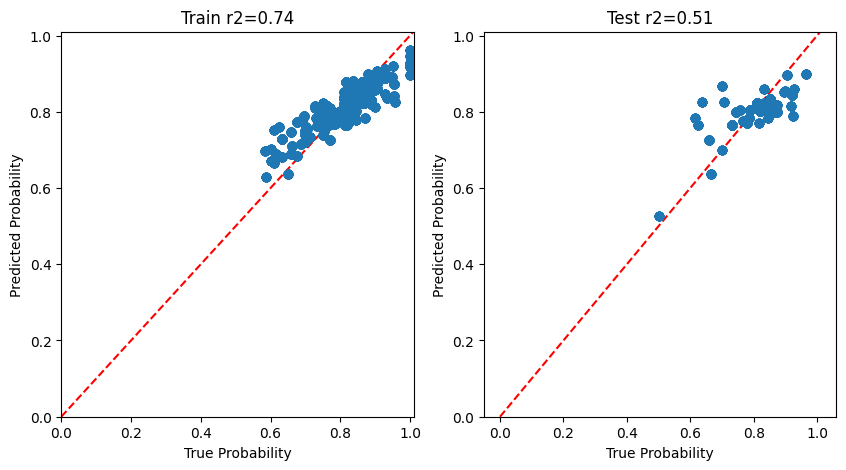

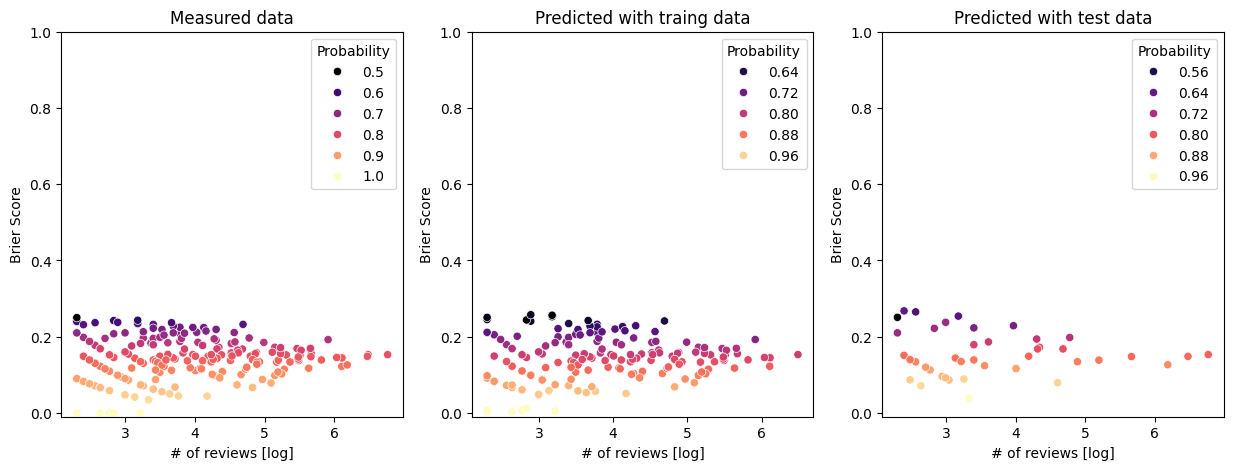

In [35]:
print_model_evaluation(clf_pipeline, X_train, y_train, X_test, y_test)
plot_probabilities(clf_pipeline, X_train, y_train, X_test, y_test)
plot_brier_score(clf_pipeline, X_train, y_train, X_test, y_test)

Conclusion:
* The model does a good job in predicting the Recommended IND, as shown by the classification metrics.
* The Brier Score is in a similar range to the measured data. It basically reflects the Bernoulli process (see 01_data_understanding notebook)
* The correlation between the measured and estimated recommendation probabilities for the articles could be better

# Fine-Tune Model

Run a randomized search through different parameters to fine-tune the hyperparameters

In [435]:
def r2_scorer(estimator, X, y):
  """ Uses the correlation between the probabilities as score """ 
  x_values = calculate_probability(X, y)
  y_values = calculate_probability(X, estimator.predict_proba(X)[:, 1])
  return r2_score(x_values, y_values)
 
 
param_grid = [{'clf__n_estimators': [50, 100, 200],
               'clf__max_features': ["sqrt", "log2"],
               'clf__min_samples_leaf': [2, 5, 7],
               'preprocess__store__selector__include_division': [True, False],
               'preprocess__store__selector__include_department': [True, False],
               'preprocess__store__selector__include_class': [True, False],
               'preprocess__review__selector__title__include_char': [True, False],
               'preprocess__review__selector__title__include_nlp': [True, False],
               'preprocess__review__selector__title__include_sentiment': [True, False],
               'preprocess__review__selector__text__include_char': [True, False],
               'preprocess__review__selector__text__include_nlp': [True, False],
               'preprocess__review__selector__text__include_sentiment': [True, False],
               'preprocess__feedback__k': [3, 7],               
               }] 


grid = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_grid,         
    cv=GroupKFold(n_splits=5),
    scoring=r2_scorer,
    n_jobs=-1,
    refit=True,
    random_state=42,
    n_iter=200,
)

Fit pipeline

In [ ]:
grid.fit(X_train, y_train, groups=X_train["Clothing ID"].values);

In [437]:
grid.best_params_

{'preprocess__store__selector__include_division': False,
 'preprocess__store__selector__include_department': False,
 'preprocess__store__selector__include_class': True,
 'preprocess__review__selector__title__include_sentiment': True,
 'preprocess__review__selector__title__include_nlp': True,
 'preprocess__review__selector__title__include_char': True,
 'preprocess__review__selector__text__include_sentiment': True,
 'preprocess__review__selector__text__include_nlp': True,
 'preprocess__review__selector__text__include_char': False,
 'preprocess__feedback__k': 7,
 'clf__n_estimators': 50,
 'clf__min_samples_leaf': 5,
 'clf__max_features': 'sqrt'}

Evaluate best estimator

Accuracy: train=0.887 test=0.851.
Precission: train=0.891 test=0.842.
Recall: train=0.887 test=0.851.
F1: train=0.869 test=0.820.


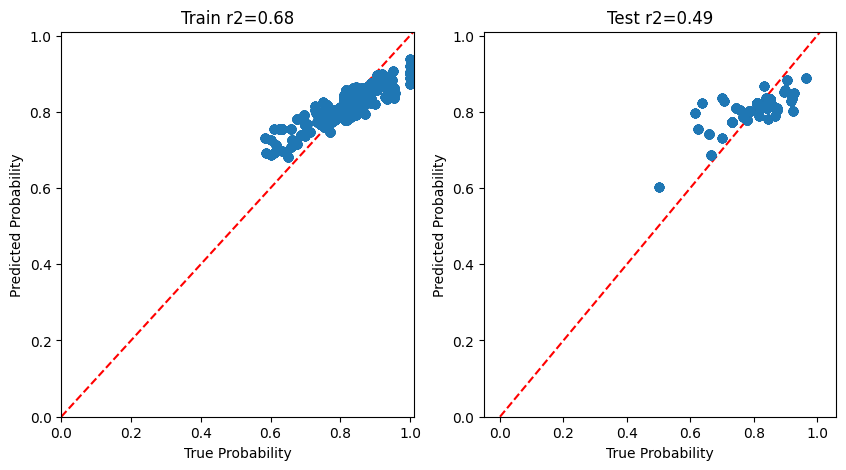

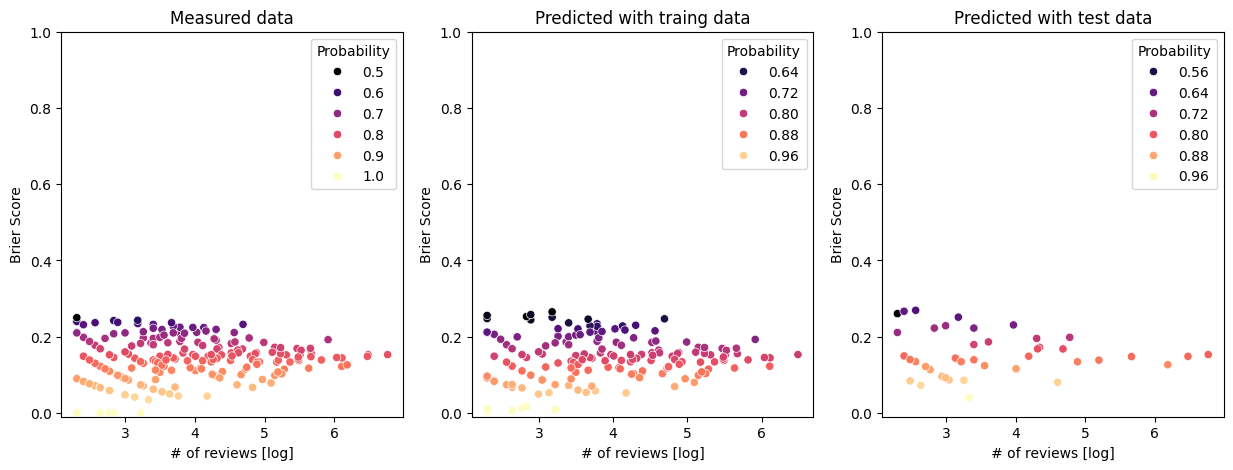

In [ ]:
base_pipeline_best = grid.best_estimator_

print_model_evaluation(base_pipeline_best, X_train, y_train, X_test, y_test)
plot_probabilities(base_pipeline_best, X_train, y_train, X_test, y_test)
plot_brier_score(base_pipeline_best, X_train, y_train, X_test, y_test)

Conclusions:
* The model found in the search is worse than the one set initially.
* The only columns from the NLP analysis that are used refer to the sentiment analysis.

# Save model

Export the initial model since the results are better as the ones found with the randomized search.

In [30]:
artifact = {
    "model": clf_pipeline,
    "metadata": {
        "sklearn_version": sklearn.__version__,
        "python_version": "3.12.11",
        "numpy_version": np.__version__,
        "pandas_version": pd.__version__,
        "feature_order": list(X_train.columns),
        "target_name": "recommended",
        "trained_at": "2025-10-25",
    }
}

file_path = Path(os.path.abspath('')).parent / "data" / "model.joblib"
joblib.dump(artifact, file_path)

['c:\\workspace\\sources_git\\dsnd-pipelines-project\\data\\model.joblib']